# NMA CN Project

- **Pod**: careful wolfs ⚠️🐺
- **Question**: is there a difference in neural activation at the cell level following stimulus presentation in the active vs passive conditions?

## References

- [[AllenNB1]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_ophys_data_access.html) Download data using the AllenSDK or directly from our Amazon S3 bucket
- [[AllenNB2]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_ophys_dataset_manifest.html) Identify experiments of interest using the dataset manifest
- [[AllenNB3]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_load_ophys_data.html) Load and visualize data from a 2-photon imaging experiment
- [[AllenNB4]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_mouse_history.html) Examine the full training history of one mouse
- [[AllenNB5]](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_compare_across_trial_types.html) Compare behavior and neural activity across different trial types in the task

## Imports

Import and setup Python packages. You should not need to touch this section.

In [1]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

/home/seungjaeryanlee/anaconda3/envs/nma-cn/lib/python3.8/site-packages/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
np.random.seed(42)

## Setup AllenSDK

Configure AllenSDK to get `cache`, `sessions_df` and `experiments_df`. Data will be stored in `./allensdk_storage` by default.

In [3]:
DATA_STORAGE_DIRECTORY = Path("./allensdk_storage")

In [4]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=DATA_STORAGE_DIRECTORY)

The data manifest is comprised of three types of tables:

1. `behavior_session_table`
2. `ophys_session_table`
3. `ophys_experiment_table`

The` behavior_session_table` contains metadata for every **behavior session** in the dataset. Some behavior sessions have 2-photon data associated with them, while others took place during training in the behavior facility. The different training stages that mice are progressed through are described by the session_type.

The `ophys_session_table` contains metadata for every 2-photon imaging (aka optical physiology, or ophys) session in the dataset, associated with a unique `ophys_session_id`. An **ophys session** is one continuous recording session under the microscope, and can contain different numbers of imaging planes (aka experiments) depending on which microscope was used. For Scientifica sessions, there will only be one experiment (aka imaging plane) per session. For Multiscope sessions, there can be up to eight imaging planes per session. Quality Control (QC) is performed on each individual imaging plane within a session, so each can fail QC independent of the others. This means that a Multiscope session may not have exactly eight experiments (imaging planes).

The `ophys_experiment_table` contains metadata for every **ophys experiment** in the dataset, which corresponds to a single imaging plane recorded in a single session, and associated with a unique `ophys_experiment_id`. A key part of our experimental design is targeting a given population of neurons, contained in one imaging plane, across multiple `session_types` (further described below) to examine the impact of varying sensory and behavioral conditions on single cell responses. The collection of all imaging sessions for a given imaging plane is referred to as an **ophys container**, associated with a unique `ophys_container_id`. Each ophys container may contain different numbers of sessions, depending on which experiments passed QC, and how many retakes occured (when a given session_type fails QC on the first try, an attempt is made to re-acquire the `session_type` on a different recording day - this is called a retake, also described further below).

*Text copied from [[AllenNB2]](#References)*

In [5]:
sessions_df = cache.get_behavior_session_table()

In [6]:
experiments_df = cache.get_ophys_experiment_table()

## Specify Experiment

Get 1 active and 1 passive experiment that meet the following criteria:
- Excitatory cells
- Single-plane imaging

### Cre Line and Reporter Line

<img style="width: 50%" src="images/cre_lines.png">

 The `cre_line` determines which genetically identified neuron type will be labeled by the reporter_line.
 
 This dataset have 3 `cre_line`:
 - **Slc17a7-IRES2-Cre**, which labels excitatory neurons across all cortical layers
 - **Sst-IRES-Cre** which labels somatostatin expressing inhibitory interneurons
 - **Vip-IRES-Cre**, which labels vasoactive intestinal peptide expressing inhibitory interneurons
 
*Text copied from [[AllenNB2]](#References)*

In [7]:
experiments_df["cre_line"].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

There are also 3 `reporter_line`:
 - **Ai93(TITL-GCaMP6f)**, which expresses the genetically encoded calcium indicator GCaMP6f (f is for 'fast', this reporter has fast offset kinetics, but is only moderately sensitive to calcium relative to other sensors) in cre labeled neurons
 - **Ai94(TITL-GCaMP6s)**, which expresses the indicator GCaMP6s (s is for 'slow', this reporter is very sensitive to calcium but has slow offset kinetics), and
 - **Ai148(TIT2L-GC6f-ICL-tTA2**, which expresses GCaMP6f using a self-enhancing system to achieve higher expression than other reporter lines (which proved necessary to label inhibitory neurons specifically). 

In [8]:
experiments_df["reporter_line"].unique()

array(['Ai148(TIT2L-GC6f-ICL-tTA2)', 'Ai94(TITL-GCaMP6s)',
       'Ai93(TITL-GCaMP6f)'], dtype=object)

The specific `indicator` expressed by each `reporter_line` also has its own column in the table.

In [9]:
experiments_df["indicator"].unique()

array(['GCaMP6f', 'GCaMP6s'], dtype=object)

`full_genotype` contains information for both cre line and reporter line.

In [10]:
experiments_df["full_genotype"].unique()

array(['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'],
      dtype=object)

---

We are looking at excitatory cells, so we should use `cre_line` of `Slc17a7-IRES2-Cre`. We did not select a particular `reporter_line`, so we can either.

In [11]:
FULL_GENOTYPE = "Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt"

### Project Code

<img style="width: 50%" src="images/datasets.png">

"The distinct groups of mice are referred to as dataset variants and can be identified using the `project_code` column." [[AllenNB2]](#References)

In [12]:
experiments_df["project_code"].unique()

array(['VisualBehaviorMultiscope', 'VisualBehaviorTask1B',
       'VisualBehavior'], dtype=object)

---

We are interested in single-plane imaging, so either `VisualBehavior` or `VisualBehaviorTask1B` works.

In [13]:
# We are looking at single-plane imaging
# "VisualBehavior" or "VisualBehaviorTask1B"
PROJECT_CODE = "VisualBehavior"

### Experiment

<img style="width: 50%" src="images/data_structure.png">

(Note that we are looking at single-plane imaging, so there is only one row (container) per mouse.)

#### `MOUSE_ID`

"The mouse_id is a 6-digit unique identifier for each experimental animal in the dataset." [[AllenNB2]](#References)

---

We retrieve all mouse that can be used for our experiment and select one mouse.

In [14]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("full_genotype == @FULL_GENOTYPE") \
              ["mouse_id"].unique()

array([449441, 448900, 456564, 479426, 457766, 423606, 442709])

In [15]:
MOUSE_ID = 449441

#### `ACTIVE_SESSION`, `PASSIVE_SESSION`

<img style="width: 50%" src="images/experiment_design.png">

The session_type for each behavior session indicates the behavioral training stage or 2-photon imaging conditions for that particular session. This determines what stimuli were shown and what task parameters were used.

During the 2-photon imaging portion of the experiment, mice perform the task with the same set of images they saw during training (either image set A or B), as well as an additional novel set of images (whichever of A or B that they did not see during training). This allows evaluation of the impact of different sensory contexts on neural activity - familiarity versus novelty.
 - Sessions with **familiar images** include those starting with `OPHYS_0`, `OPHYS_1`, `OPHYS_2`, and `OPHYS_3`.
 - Sessions with **novel images** include those starting with `OPHYS_4`, `OPHYS_5`, and `OPHYS_6`.

Interleaved between **active behavior sessions** are **passive viewing sessions** where mice are given their daily water ahead of the sesssion (and are thus satiated) and view the stimulus with the lick spout retracted so they are unable to earn water rewards. This allows comparison of neural activity in response to stimuli under different behavioral context - active task engagement and passive viewing without reward. There are two passive sessions:
 - `OPHYS_2_images_A_passive`: passive session with familiar images
 - `OPHYS_5_images_A_passive`: passive session with novel images



*Text copied from [[AllenNB2]](#References)*

---

We check which sessions are available for this particular mouse and select one active and one passive session type. Not all sessions may be availble due to QC.

In [16]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("full_genotype == @FULL_GENOTYPE") \
              .query("mouse_id == @MOUSE_ID") \
              ["session_type"].unique()

array(['OPHYS_2_images_A_passive', 'OPHYS_1_images_A', 'OPHYS_4_images_B',
       'OPHYS_6_images_B', 'OPHYS_5_images_B_passive'], dtype=object)

In [17]:
ACTIVE_SESSION_TYPE = "OPHYS_1_images_A"
PASSIVE_SESSION_TYPE = "OPHYS_2_images_A_passive"

#### `ACTIVE_EXPERIMENT_ID`, `PASSIVE_EXPERIMENT_ID`

We retrieve the `ophys_experiment_id` of each session type we chose. We need this ID to get the experiment data.

In [18]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("full_genotype == @FULL_GENOTYPE") \
              .query("mouse_id == @MOUSE_ID") \
              .query("session_type == @ACTIVE_SESSION_TYPE") \
              .index

Int64Index([879332693], dtype='int64', name='ophys_experiment_id')

In [19]:
ACTIVE_EXPERIMENT_ID = 879332693

In [20]:
experiments_df.query("project_code == @PROJECT_CODE") \
              .query("full_genotype == @FULL_GENOTYPE") \
              .query("mouse_id == @MOUSE_ID") \
              .query("session_type == @PASSIVE_SESSION_TYPE").index

Int64Index([877696762], dtype='int64', name='ophys_experiment_id')

In [21]:
PASSIVE_EXPERIMENT_ID = 877696762

## Explore Experiment

We can now download the experiment. Each experiment will be approximately 2GB in size.

In [22]:
active_experiment = cache.get_behavior_ophys_experiment(ACTIVE_EXPERIMENT_ID)

In [23]:
active_experiment

This returns an instance of `BehaviorOphysExperiment`. It contains multiple attributes that we will need to explore.

### What's In Here?

#### `dff_traces`

"`dff_traces` dataframe contains traces for all neurons in this experiment, unaligned to any events in the task." [[AllenNB3]](#References)

In [24]:
active_experiment.dff_traces.head()

,cell_roi_id,dff
cell_specimen_id,,
1086601848,1080867796,"[0.28201794368039823, 0.1903022438869266, 0.21..."
1086602069,1080867804,"[0.13884965897445056, 0.3963619942985226, 0.24..."
1086635982,1080867837,"[0.5498754867600153, 0.26557468920820837, 0.43..."
1086578646,1080867844,"[0.20886659311964556, 0.08442318243036104, 0.2..."
1086598188,1080867847,"[0.28967144653172083, 0.49236151316004095, 0.4..."


Since `dff` is stored as a list, we need to get timestamps for each of those numbers.

#### `ophys_timestamps`

`ophys_timestamps` contains the timestamps of every record.

In [25]:
active_experiment.ophys_timestamps

array([2.55695000e+00, 2.58926000e+00, 2.62157000e+00, ...,
       4.53777515e+03, 4.53780747e+03, 4.53783979e+03])

Let's do a sanity check by checking the length of both lists.

In [26]:
print(f"dff has length {len(active_experiment.dff_traces.iloc[0]['dff'])}")
print(f"timestamp has length {len(active_experiment.ophys_timestamps)}")

dff has length 140324
timestamp has length 140324


#### `stimulus_presentations`

We also need timestamps of when stimulus was presented. This information is contained in `stimulus_presentations`.

In [27]:
active_experiment.stimulus_presentations.head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25020,18002.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17987,307.53005,307.78025,False
1,0.25022,18047.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18032,308.28098,308.53120,False
2,0.24985,18092.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18077,309.03163,309.28148,False
3,0.25021,18137.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18122,309.78188,310.03209,False
4,0.25020,18182.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18167,310.53247,310.78267,False


During imaging sessions, stimulus presentations (other than the change and pre-change images) are omitted with a 5% probability, resulting in some inter stimlus intervals appearing as an extended gray screen period. [[AllenNB2]](#References)

<img style="width: 50%" src="images/omissions.png">

In [28]:
active_experiment.stimulus_presentations.query("omitted").head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
22,0.25,NaN,8,omitted,omitted,0,True,18976,324.02684,324.27684,False
119,0.25,NaN,8,omitted,omitted,1,True,23341,396.83648,397.08648,False
121,0.25,NaN,8,omitted,omitted,2,True,23431,398.33747,398.58747,False
123,0.25,NaN,8,omitted,omitted,3,True,23521,399.83869,400.08869,False
146,0.25,NaN,8,omitted,omitted,4,True,24556,417.10313,417.35313,False


### Visualization

#### Plot dF/F Trace

Let's choose some random `cell_specimen_id` (1086601848) and plots its dff trace.

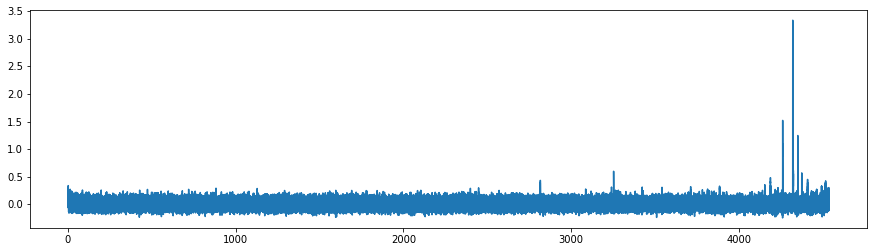

In [29]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(
    active_experiment.ophys_timestamps,
    active_experiment.dff_traces.loc[1086601848]["dff"],
)

fig.show()

#### Plot Stimulus

Let's also plot stimulus for a short interval.

*Part of code from [[AllenNB3]](#References)*

In [30]:
# Create a color map for each image
unique_stimuli = [stimulus for stimulus in active_experiment.stimulus_presentations['image_name'].unique()]
colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
# Keep omitted image as white
colormap['omitted'] = (1,1,1)

In [31]:
stimulus_presentations_sample = active_experiment.stimulus_presentations.query('stop_time >= 400 and start_time <= 450')

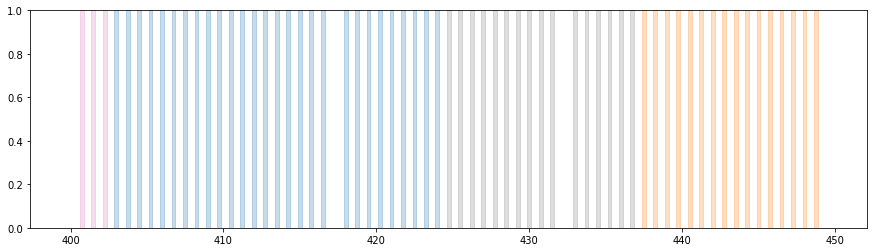

In [32]:
fig, ax = plt.subplots(figsize=(15, 4))

for idx, stimulus in stimulus_presentations_sample.iterrows():
    ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=colormap[stimulus['image_name']], alpha=0.25)
    
fig.show()

#### Both

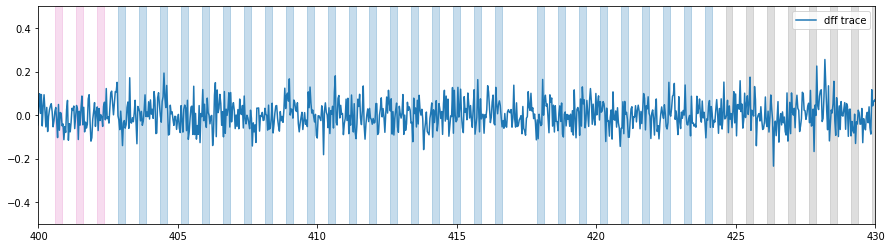

In [33]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(
    active_experiment.ophys_timestamps,
    active_experiment.dff_traces.loc[1086601848]["dff"],
)

for idx, stimulus in stimulus_presentations_sample.iterrows():
    ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=colormap[stimulus['image_name']], alpha=0.25)
    
ax.set_xlim(400, 430)
ax.set_ylim(-0.5, 0.5)
ax.legend(["dff trace"])

fig.show()

## Cell Selection

We would like to limit ourselves to looking at cells that respond to a presentation of a visual stimuli.

To understand which cells respond, we check the dF/F traces of cells 250ms before stimulus onset and 250ms after stimulus onset. Then, we choose the cells with the biggest difference in mean dF/F.

In [34]:
TIME_BEFORE_STIMULUS = 0.25
TIME_AFTER_STIMULUS = 0.25

### Helper Functions

In [35]:
def get_cell_specimen_ids(experiment):
    """
    Get all the cell specimen ids recorded in the experiment.
    """
    return experiment.dff_traces.index

In [36]:
def get_indices_in_interval(experiment, start, end):
    """
    Get all indices of timestamps where dF/F trace was recorded during a specified interval.
    """
    indices = np.argwhere((experiment.ophys_timestamps >= start) & (experiment.ophys_timestamps <= end))[:, 0]
    return indices

In [37]:
def get_timestamps_in_interval(experiment, start, end):
    """
    Get all timestamps when dF/F trace was recorded during a specified interval.
    """
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.ophys_timestamps[indices]

In [38]:
def get_dff_in_interval(experiment, cell_specimen_id, start, end):
    """
    Get dF/F trace for one cell during a specified interval.
    """
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.dff_traces.loc[cell_specimen_id]["dff"][indices[0]:indices[-1]+1]

### Code

In [39]:
active_stimulus_start_times = active_experiment.stimulus_presentations["start_time"]

In [40]:
dff_matrix = np.vstack(active_experiment.dff_traces.dff.values)

In [41]:
dff_matrix.shape # shape=(Number of cells, Number of records)

(415, 140324)

In [42]:
diff_traces_per_stimulus = []
for stimulus_start_time in tqdm(active_stimulus_start_times):
    before_indices = get_indices_in_interval(active_experiment, stimulus_start_time-TIME_BEFORE_STIMULUS, stimulus_start_time)
    after_indices = get_indices_in_interval(active_experiment, stimulus_start_time, stimulus_start_time+TIME_AFTER_STIMULUS)
    before_mean_traces = np.mean(dff_matrix[:, before_indices], axis=1)
    after_mean_traces = np.mean(dff_matrix[:, after_indices], axis=1)
    diff_traces = after_mean_traces - before_mean_traces
    diff_traces_per_stimulus.append(diff_traces)

100%|██████████| 4807/4807 [00:02<00:00, 2074.19it/s]


In [43]:
diff_matrix = np.stack(diff_traces_per_stimulus, axis=1)

In [44]:
mean_diff_per_cell = np.mean(diff_matrix, axis=1)

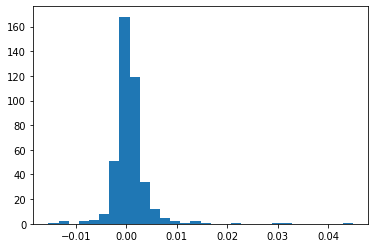

In [45]:
plt.hist(mean_diff_per_cell, bins=30);

In [46]:
np.max(mean_diff_per_cell)

0.04483521741441901

In [47]:
cell_specimen_ids = get_cell_specimen_ids(active_experiment)
selected_cell_specimen_id = cell_specimen_ids[np.argmax(mean_diff_per_cell)]

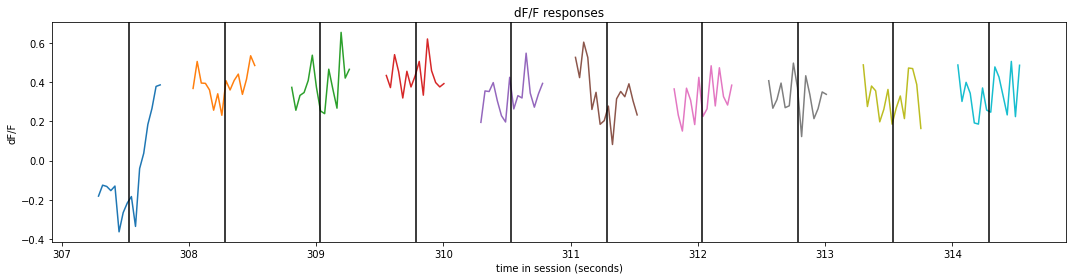

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (15, 4))

for stimulus_start_time in active_stimulus_start_times[:10]:
    for cell_specimen_id in [selected_cell_specimen_id]:
        ax.plot(
            get_timestamps_in_interval(active_experiment, stimulus_start_time-0.25, stimulus_start_time+0.25),
            get_dff_in_interval(active_experiment, cell_specimen_id, stimulus_start_time-0.25, stimulus_start_time+0.25),
        )
    ax.axvline(x=stimulus_start_time, color="k", linestyle="-")

ax.set_title('dF/F responses')
ax.set_ylabel('dF/F')
ax.set_xlabel('time in session (seconds)')
fig.tight_layout()
fig.show()

## Hypothesis Testing

In [49]:
selected_cell_specimen_id

1086578313

In [50]:
passive_experiment = cache.get_behavior_ophys_experiment(PASSIVE_EXPERIMENT_ID)

In [51]:
passive_stimulus_df = passive_experiment.stimulus_presentations

In [52]:
passive_stimulus_start_times = passive_stimulus_df["start_time"]

### One stimulus

In [53]:
active_stimulus_start_time = active_stimulus_start_times[0]
passive_stimulus_start_time = passive_stimulus_start_times[0]

In [54]:
active_timestamps = get_timestamps_in_interval(active_experiment, active_stimulus_start_time, active_stimulus_start_time+0.250)
active_dff = get_dff_in_interval(active_experiment, selected_cell_specimen_id, active_stimulus_start_time, active_stimulus_start_time+0.250)

In [55]:
passive_timestamps = get_timestamps_in_interval(passive_experiment, passive_stimulus_start_time, passive_stimulus_start_time+0.250)
passive_dff = get_dff_in_interval(passive_experiment, selected_cell_specimen_id, passive_stimulus_start_time, passive_stimulus_start_time+0.250)

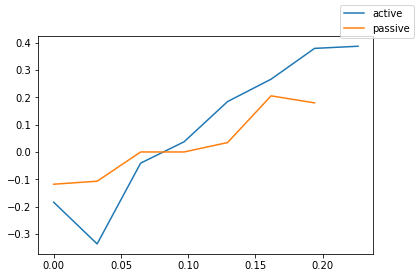

In [56]:
fig, ax = plt.subplots()
ax.plot(active_timestamps - active_timestamps[0], active_dff, label="active")
ax.plot(passive_timestamps - passive_timestamps[0], passive_dff, label="passive")
fig.legend()
fig.show()

### Multiple stimulus (WIP)

In [57]:
diff_traces_per_stimulus = []
active_dffs = []
for stimulus_start_time in tqdm(active_stimulus_start_times):
    dff = get_dff_in_interval(active_experiment, selected_cell_specimen_id, stimulus_start_time, stimulus_start_time+0.250)
    active_dffs.append(dff)

100%|██████████| 4807/4807 [00:01<00:00, 2683.35it/s]


In [58]:
from collections import Counter

Counter([len(active_dff) for active_dff in active_dffs])

Counter({8: 3537, 7: 1270})